# This notebook produces predictions from theory for consistency checks

In [1]:
import numpy as np
import pandas as pd
import healpy as hp
import matplotlib.pyplot as plt
plt.style.use("seaborn-notebook")
import pyccl as ccl

from IPython.display import HTML
from IPython.display import display

Last Updated: 17 July 2020

### Tasks:
* Generate cross power spectra from CCL: DONE
* Generate correlated synthetic maps using healpy with theory $C_l$s: DONE
* Study the correlation of Planck noise power spectrum with theory $C_l$s: TODO
* Calculate RCC for ELG X CMB Lensing from theory: DONE

### Tests:

* Recover $C_l$s from full-sky no noise signal maps: DONE
* Recover $C_l$s from masked-sky no noise signal maps by correcting for $f_{sky}$: DONE
* Recover $C_l$s from full-sky noised signal maps: TODO
* Recover $C_l$s from masked-sky noised signal maps: TODO
* Verify that hp.UNSEEN has no affect on $C_l$ calculations: DONE
* Recover $C_l$s from smoothed full-sky no noise signal maps: DONE
* Recover $C_l$s from smoothed masked-sky no noise signal maps: TODO
* Recover $C_l$s from smoothed masked-sky noised signal maps: TODO
* Calculate RCC for each of the prior tests and compare with theory: TODO

Binning function from Sukhdeep

In [2]:
# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)

import itertools 

def bin_mat(r=[],mat=[],r_bins=[]):#works for cov and skewness
    bin_center=0.5*(r_bins[1:]+r_bins[:-1])
    n_bins=len(bin_center)
    ndim=len(mat.shape)
    mat_int=np.zeros([n_bins]*ndim,dtype='float64')
    norm_int=np.zeros([n_bins]*ndim,dtype='float64')
    bin_idx=np.digitize(r,r_bins)-1
    r2=np.sort(np.unique(np.append(r,r_bins))) #this takes care of problems around bin edges
    dr=np.gradient(r2)
    r2_idx=[i for i in np.arange(len(r2)) if r2[i] in r]
    dr=dr[r2_idx]
    r_dr=r*dr

    ls=['i','j','k','l']
    s1=ls[0]
    s2=ls[0]
    r_dr_m=r_dr
    for i in np.arange(ndim-1):
        s1=s2+','+ls[i+1]
        s2+=ls[i+1]
        r_dr_m=np.einsum(s1+'->'+s2,r_dr_m,r_dr)#works ok for 2-d case

    mat_r_dr=mat*r_dr_m
    for indxs in itertools.product(np.arange(min(bin_idx),n_bins),repeat=ndim):
        x={}#np.zeros_like(mat_r_dr,dtype='bool')
        norm_ijk=1
        mat_t=[]
        for nd in np.arange(ndim):
            slc = [slice(None)] * (ndim)
            #x[nd]=bin_idx==indxs[nd]
            slc[nd]=bin_idx==indxs[nd]
            if nd==0:
                mat_t=mat_r_dr[slc]
            else:
                mat_t=mat_t[slc]
            norm_ijk*=np.sum(r_dr[slc[nd]])
        if norm_ijk==0:
            continue
        mat_int[indxs]=np.sum(mat_t)/norm_ijk
        norm_int[indxs]=norm_ijk
    return bin_center,mat_int

## Section 1: Systematic Tests

### $C^{\kappa \kappa}_{l}$ from theory

In [3]:
#define cosmology Planck 2018 CMB Lensing Fiducial 1807.06210 last bullet point above Sec 2.2
cosmo = ccl.Cosmology(Omega_c = 0.268, Omega_b = 0.049,
        h = 0.670, n_s = 0.964, A_s = 2.119e-9,
        m_nu_type='list', m_nu = np.array([0, 0, 0.06]),
        transfer_function='boltzmann_camb') 

In [4]:
#define params
lmin = 100; lmax = 1500
ell = np.arange(0, lmax, 1)
fs = 18
alpha = 0.5
NSIDE = 1024
SEED = 1234

In [5]:
#calculate theoretical Cls
cmbl = ccl.CMBLensingTracer(cosmo, z_source=1090.)
cls_cmb_th = ccl.angular_cl(cosmo, cmbl, cmbl, ell)

/home/tanveer/anaconda3/lib/python3.7/site-packages/pyccl/core.py:678: CCLWarning: CCL does not properly compute the linear growth rate in cosmological models with massive neutrinos!
  category=CCLWarning)


### $C^{g g}_{l}$ from theory

Text(0.5, 1.0, 'dNdz from FDR')

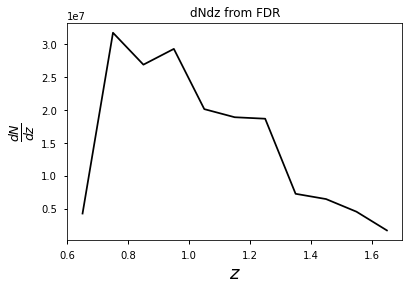

In [6]:
#read in dNdz
dNdzddeg2 = pd.read_csv("data/dNdz", sep=" ")

z = dNdzddeg2['z']
area = 14000
dNdz = dNdzddeg2['dNdzddeg2'] * area

fs = 18

plt.plot(z, dNdz, 'k-')
plt.xlabel(r"$z$", fontsize = fs)
plt.ylabel(r"$\frac{dN}{dz}$", fontsize = fs)
plt.title("dNdz from FDR")

In [7]:
#set constant bias
b = 1.25*np.ones(len(z))

#Create CCL tracer object for galaxy clustering
elgl = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,dNdz), bias=(z,b))

In [8]:
#calculate theoretical Cls
cls_elg_th = ccl.angular_cl(cosmo, elgl, elgl, ell)

### $C^{\kappa g}_{l}$ from theory

In [9]:
#calculate theoretical Cls
cls_cross_th = ccl.angular_cl(cosmo, elgl, cmbl, ell)

All the three power spectra together:

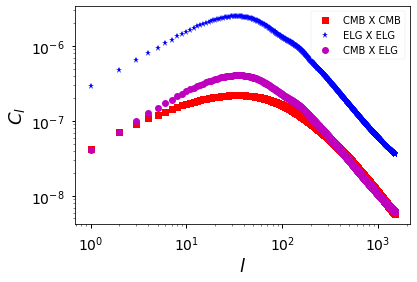

In [10]:
plt.xlabel('$l$',fontsize=fs)
plt.ylabel('$C_{l}$',fontsize=fs)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xscale('log')


plt.plot(ell, cls_cmb_th, 'rs', label = "CMB X CMB")
plt.plot(ell, cls_elg_th, 'b*', label = "ELG X ELG")
plt.plot(ell, cls_cross_th, 'mo', label = "CMB X ELG")
plt.legend(loc = 'best')

Generate binned power spectra with $100l$s per bin:

In [11]:
bins = np.arange(0, lmax+1, 100)
ELL, cLs_cmb_th = bin_mat(ell, cls_cmb_th, bins)
_, cLs_elg_th = bin_mat(ell, cls_elg_th, bins)
_, cLs_cross_th = bin_mat(ell, cls_cross_th, bins)

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


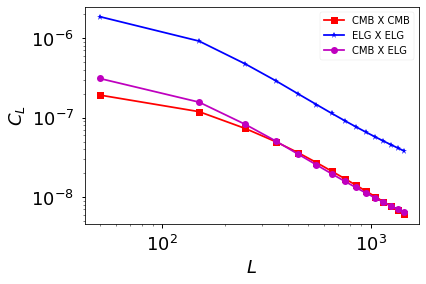

In [12]:
plt.xlabel('$L$',fontsize=fs)
plt.ylabel('$C_{L}$',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.loglog(ELL, cLs_cmb_th, 'rs', ls = '-', label = "CMB X CMB")
plt.loglog(ELL, cLs_elg_th, 'b*', ls = '-', label = "ELG X ELG")
plt.loglog(ELL, cLs_cross_th, 'mo', ls = '-', label = "CMB X ELG")
plt.legend(loc = 'best')

Function to generate plots  from synthetic maps to compare against theory

In [13]:
def plot_powerspectra(cls, fields, ELL_min = lmin, ELL_max = lmax, **kwargs):
    """Calculates power spectra using anafast and produces plots against theory
    cls: list of cls to be plotted
    fields: 'gg', 'kk' or 'kg'
    ell_min: minimum ell to be plotted
    ell_max: max ell to be plotted
    label: plot legend label"""
    
    #bin cls
    
    _, cLs = bin_mat(ell, cls, bins)
    
    fltr_ELL = (ELL > ELL_min) & (ELL < ELL_max) #filter results between range
    
    if(fields == 'kk'):
        plt.loglog(ELL[fltr_ELL], cLs_cmb_th[fltr_ELL], 'rs', label = "CMB Theory")
        plt.ylabel(r"$C^{\kappa \kappa}_{L}$", fontsize = fs)
    elif(fields == 'gg'):
        plt.loglog(ELL[fltr_ELL], cLs_elg_th[fltr_ELL], "b*", label = "ELG Theory")
        plt.ylabel(r"$C^{g g}_{L}$", fontsize = fs)
    elif((fields == 'kg') | (fields == 'gk')):
        plt.loglog(ELL[fltr_ELL], cLs_cross_th[fltr_ELL], "mo", label = "CMB X ELG Theory")
        plt.ylabel(r"$C^{k g}_{L}$", fontsize = fs)
        
    plt.loglog(ELL[fltr_ELL], cLs[fltr_ELL], alpha = alpha, **kwargs)
    plt.xlabel(r"$L$", fontsize = fs)
    plt.legend(loc = 'best')
    plt.show() 
    
    if(fields == 'kk'):
        plt.plot(ELL[fltr_ELL], (cLs/cLs_cmb_th)[fltr_ELL], "rs", ls = '-')
    elif(fields == 'gg'):
        plt.plot(ELL[fltr_ELL], (cLs/cLs_elg_th)[fltr_ELL], "b*", ls = '-')
    elif((fields == 'kg') | (fields == 'gk')):
        plt.plot(ELL[fltr_ELL], (cLs/cLs_cross_th)[fltr_ELL], "mo", ls = '-')
        
    plt.xlabel(r"$L$", fontsize = fs)
    plt.ylabel(r"$\frac{C^{obs}_{L}}{C^{th}_{L}}$", fontsize = fs)
    plt.axhline(1)
    plt.show()

### Make synthetic maps

***Deprecated***

We are going to produce synthetic maps following Appendix of Giannantonio et al. 2008 (PhysRevD.77.123520).

Given two correlated maps $m_1$ and $m_2$, there are three power spectra $C^{11}_{l}$, $C^{12}_{l} = C^{21}_{l}$ and $C^{22}_{l}$. In this case, the coefficients of the spherical harmonics are given by:

\begin{align}
a^{1}_{lm} &= \xi_a \sqrt{C^{11}_{l}} \\
a^{2}_{lm} &= \xi_a \frac{C^{12}_{l}}{\sqrt{C^{11}_{l}}} + \xi_b \sqrt{C^{22}_{l} - \frac{\left(C^{12}_{l}\right)^2}{C^{11}_{l}}}
\end{align}

where $\xi$ is a random complex variable with mean $0$ and variance $1$, that denotes the random amplitude for a given mode. 

Now, Healpy *synfast* uses the *synalm* function to generate maps. The *synalm* function effectively does the following by taking $C_l$ as the input:

\begin{equation}
a_{lm} = \sqrt{C_l} \xi
\end{equation}

Thus, we can use this procedure to produce synthetic maps in the following way (assume $1 = \kappa and 2 = g$):

- Produce the first map, $m_1 = m_{\kappa}$ (CMB Lensing) using $C^{\kappa \kappa}_{l}$
- Produce an intermediary map, $m_p$ using $\frac{\left( C^{\kappa g}_{l} \right)^2}{C^{\kappa \kappa}_{l}}$ using the **same** seed as $m_1$.
- Produce another intermediary map with a **new** seed, $m_q$ using $C^{gg}_{l} - \frac{\left( C^{\kappa g}_{l} \right)^2}{C^{\kappa \kappa}_{l}}$
- Produce the second map, $m_2 = m_g$ (galaxy overdensity) using $m_g = m_p + m_q$

Limitations:
- This works for weakly correlated maps. For strongly correlated maps, the square root might give rise to errors. 
- This procedure only produces positive correlations due to the nature of synfast. 
    - If $C^{22}_{l}$ is negatively correlated, then the second map needs to be corrected by $m_2 *= -1$.
    - If $C^{22}_{l}$ is mixed, then produce intermediary maps $m_+$ and $m_-$ as $m_{+} = m_2$ and $m_{-} = -1 * m_2$ and afterwards $m_2 = m_{+} - m_{-}$.
    
    
---------
Also can do this by passing $C^{\kappa \kappa}_{l}$, $C^{\kappa g}_{l}$ and $C^{gg}_{l}$ to *synfast* and get $m_{\kappa}$ and $m_{g}$ out respectively.

**Note**: Produde maps using synfast as the previous method introdues some systematic biases in the cross power-spectra.

In [14]:
np.random.seed(SEED) #must specify seed to validate tests later on
m_k, m_g = hp.synfast((cls_cmb_th, cls_cross_th,  cls_elg_th), nside = 1024, pol=False)

/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/sphtfunc.py:400: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


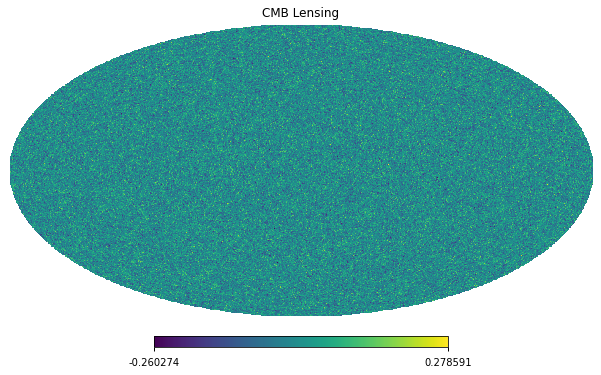

In [15]:
hp.mollview(m_k, title = "CMB Lensing")

In [16]:
cl_cmb_obs = hp.anafast(m_k, lmax = lmax - 1)
cl_elg_obs = hp.anafast(m_g, lmax = lmax - 1)
cl_cross_obs = hp.anafast(m_k, m_g, lmax = lmax - 1)

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


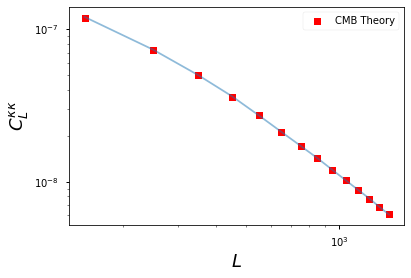

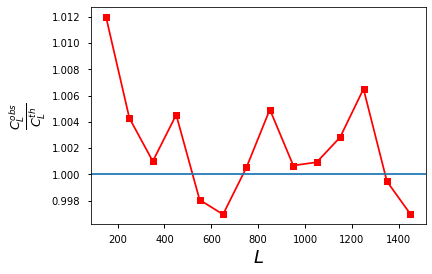

In [17]:
plot_powerspectra(cl_cmb_obs, 'kk')

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


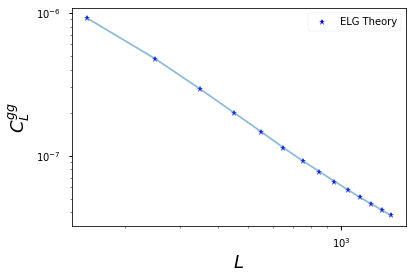

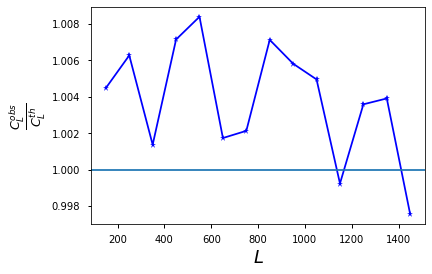

In [18]:
plot_powerspectra(cl_elg_obs, 'gg')

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


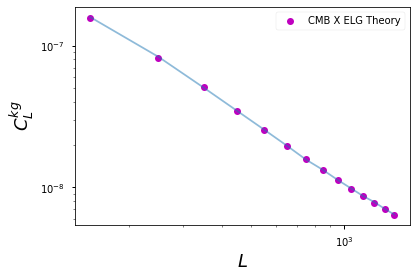

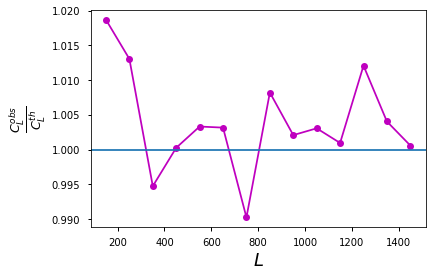

In [19]:
plot_powerspectra(cl_cross_obs, 'kg')

***Conclusion 1: Recovered $C_l$ with Fourier noise.***

#### Test 2: Add mask and calculate $\tilde{C_l}$

Add Planck lensing mask to CMB signal

/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


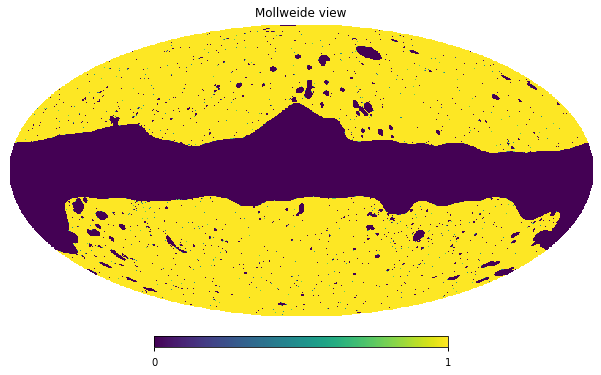

In [20]:
#Read Planck Lensing mask
lensingMask_planck = hp.fitsfunc.read_map("data/mask.fits")
lensingMask_planck = hp.ud_grade(lensingMask_planck, NSIDE)
hp.mollview(lensingMask_planck)

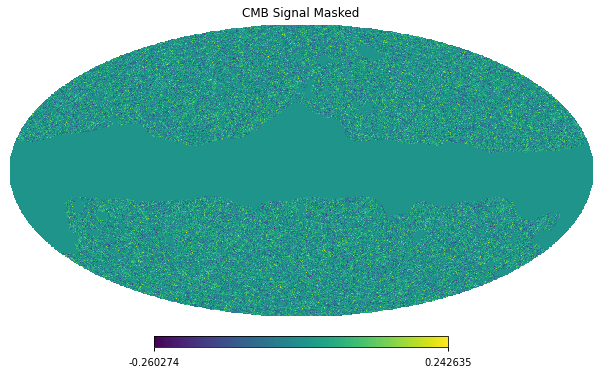

In [21]:
#Cover synthetic map with mask
m_k_masked = hp.ma(m_k, badval = 0)
m_k_masked.mask = np.logical_not(lensingMask_planck)
hp.mollview(m_k_masked, title = "CMB Signal Masked")

Add DR8 mask to ELG signal by rotating ELG catalogue from Eq. Coord. to Gal. Coord.

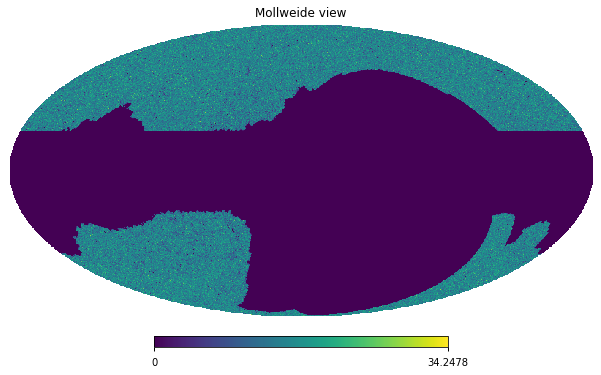

In [22]:
ranCat = np.load("data/elg_ran1024.npy") #use random ELG catalogue
#define rotator class from Eq. Coord. to Gal. Coord
r = hp.Rotator(coord=['C','G'])

ranCat_galactic = r.rotate_map_pixel(ranCat)
hp.mollview(ranCat_galactic)

In [23]:
#degrade DR8 map to remove small patches and then upgrade back to NSIDE to start making mask
ranCat_dgrade = hp.ud_grade(ranCat_galactic, 32)
ranCat_dgrade = hp.ud_grade(ranCat_dgrade, NSIDE)

#superimpose mask onto the mock map
m_g_masked = np.copy(m_g)
m_g_masked[ranCat_dgrade == 0] = 0

# generate mask
elg_mask = np.copy(m_g)
elg_mask[ranCat_dgrade == 0] = 0
elg_mask[ranCat_dgrade > 0] = 1

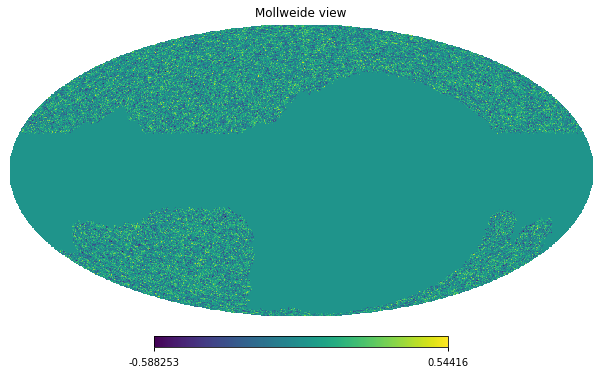

In [24]:
hp.mollview(m_g_masked)

In [25]:
#Calculate pseudo-Cls
cl_cmb_masked = hp.anafast(m_k_masked, lmax = lmax-1)
cl_elg_masked = hp.anafast(m_g_masked, lmax = lmax-1)
cl_cross_masked = hp.anafast(m_k_masked, m_g_masked, lmax = lmax-1)

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


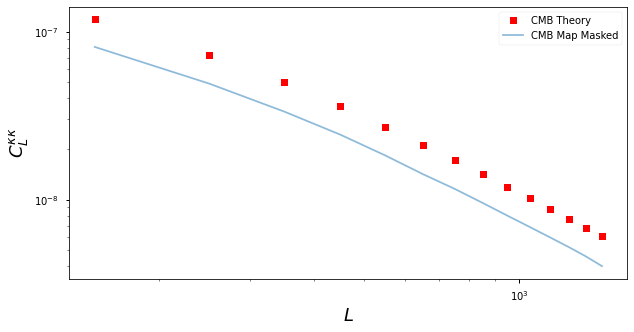

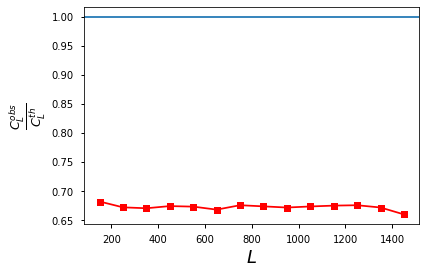

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


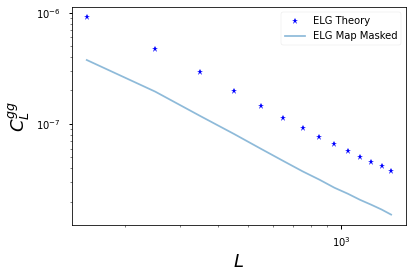

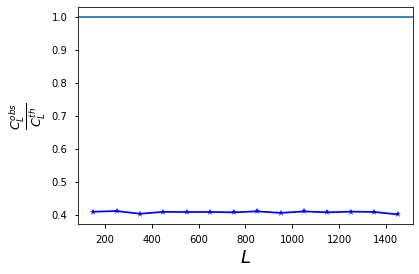

In [26]:
plt.figure(figsize=(10,5))
plot_powerspectra(cl_cmb_masked, 'kk', label = "CMB Map Masked")
plot_powerspectra(cl_elg_masked, 'gg', label = "ELG Map Masked")

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


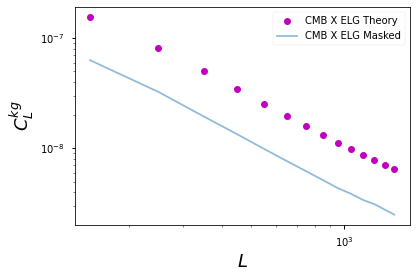

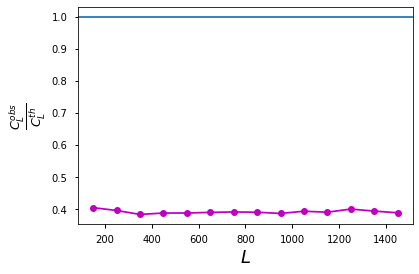

In [27]:
plot_powerspectra(cl_cross_masked, 'kg', label = "CMB X ELG Masked")

As expected, $\tilde{C_l}$ due to mask has lower signal expected. Need to correct for $f_{sky}.$

Correct for $f_{sky}$

In [28]:
#using boolean where Truth = observed pixel
fsky_lensing = lensingMask_planck.sum()/lensingMask_planck.size
fsky_elg = elg_mask.sum()/elg_mask.size

#Logical combine two masks to get cross-corr mask
cross_mask = np.logical_and(elg_mask, hp.ud_grade(lensingMask_planck, NSIDE))
fsky_cross = cross_mask.sum()/cross_mask.size

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


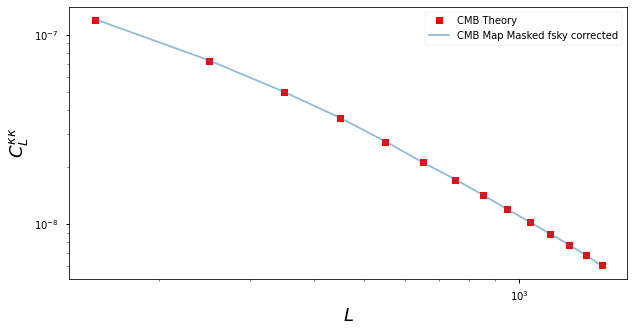

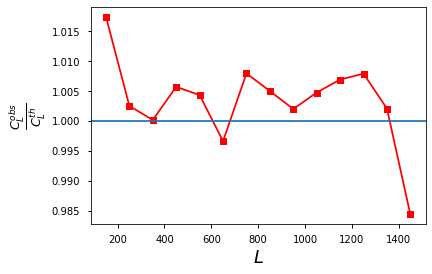

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


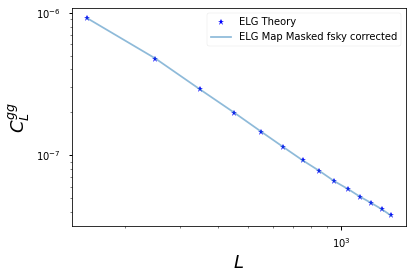

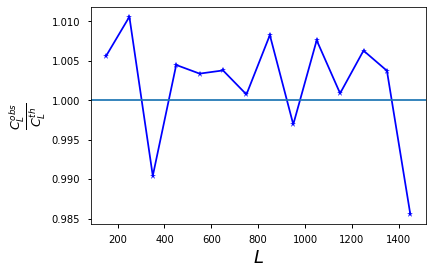

In [29]:
#auto
plt.figure(figsize=(10,5))
plot_powerspectra(cl_cmb_masked/fsky_lensing, 'kk', label = "CMB Map Masked fsky corrected")
plot_powerspectra(cl_elg_masked/fsky_elg, 'gg', label = "ELG Map Masked fsky corrected")

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


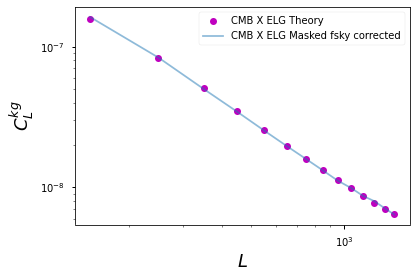

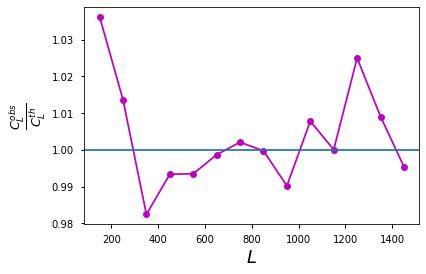

In [30]:
#cross
plot_powerspectra(cl_cross_masked/fsky_cross, 'kg', label = "CMB X ELG Masked fsky corrected")

Check difference between $C_{l}$ and $\tilde{C_l}$ where $\tilde{C_l}$ is corrected for $f_{sky}$

In [31]:
tmp = (1 - (cl_cmb_masked/fsky_lensing)/cls_cmb_th)[ell > 100]
print(f"CMB Mean = {np.round(tmp.mean(), 3)}, Std = {np.round(tmp.std(), 3)}")
tmp = (1 - (cl_elg_masked/fsky_elg)/cls_elg_th)[ell > 100]
print(f"ELG Mean = {np.round(tmp.mean(), 3)}, Std = {np.round(tmp.std(), 3)}")
tmp = (1 - (cl_cross_masked/fsky_cross)/cls_cross_th)[ell > 100]
print(f"Cross Mean = {np.round(tmp.mean(), 3)}, Std = {np.round(tmp.std(), 3)}")

CMB Mean = -0.003, Std = 0.046
ELG Mean = -0.002, Std = 0.05
Cross Mean = -0.003, Std = 0.102


/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


***Conclusion 2: Difference between $\tilde{C_l}$ and $C_l$ is very low after correcting for $f_{sky}$. However, the effect on the cross mean can be up to 0.5% level which might be an important factor.***

#### Test 3: Check whether changing badval to hp.UNSEEN affects the $C_l$ calculation

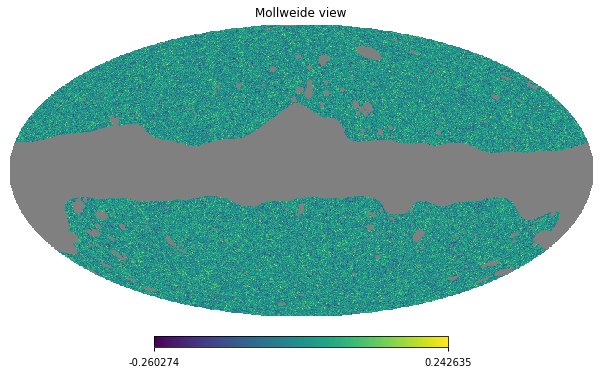

In [32]:
m_k_masked = np.copy(m_k)
m_k_masked[lensingMask_planck == 0] = hp.UNSEEN
hp.mollview(m_k_masked)

In [33]:
cl_cmb_masked2 = hp.anafast(m_k_masked, lmax = lmax-1)

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


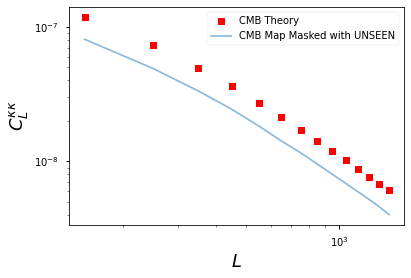

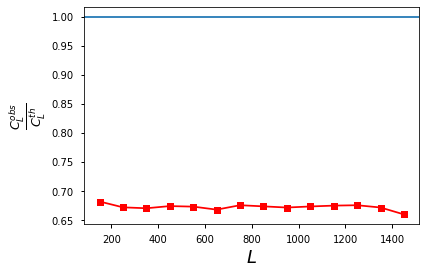

In [34]:
plot_powerspectra(cl_cmb_masked2, 'kk', label = "CMB Map Masked with UNSEEN")

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


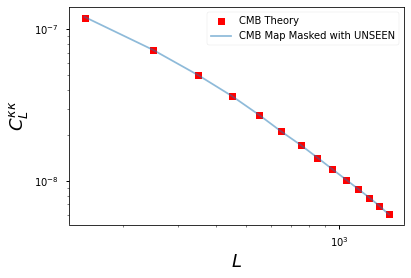

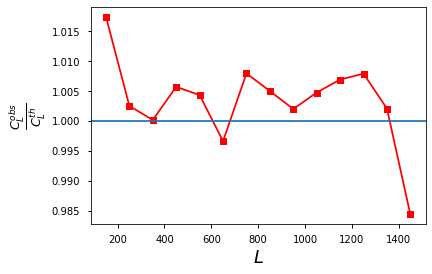

In [35]:
plot_powerspectra(cl_cmb_masked2/fsky_lensing, 'kk', label = "CMB Map Masked with UNSEEN")

***Conclusion 3: hp.UNSEEN does not affect the $\tilde{C_l}$ calculation.***

#### Test 4: Check the effect of smoothing on power spectrum recovery

We smooth the CMB Lensing map with FWHM = $5'$ (similar to Planck) and use the same random seed to generate a consistent map. 

/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/sphtfunc.py:400: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,


Sigma is 2.123305 arcmin (0.000618 rad) 
-> fwhm is 5.000000 arcmin


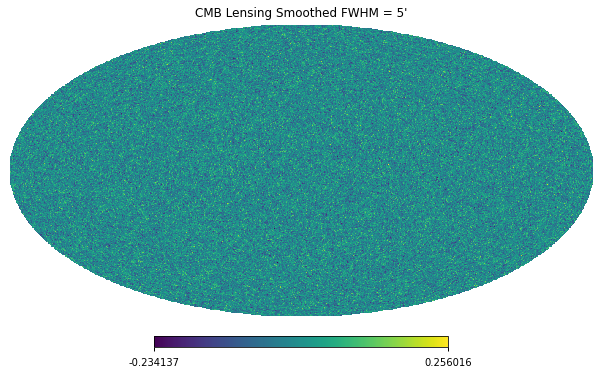

In [36]:
np.random.seed(SEED)
FWHM = 5/60 #5 arcminutes
m_k_smoothed = hp.synfast(cls_cmb_th, nside=NSIDE, pol=False, fwhm=np.deg2rad(FWHM))
hp.mollview(m_k_smoothed, title = "CMB Lensing Smoothed FWHM = 5'")

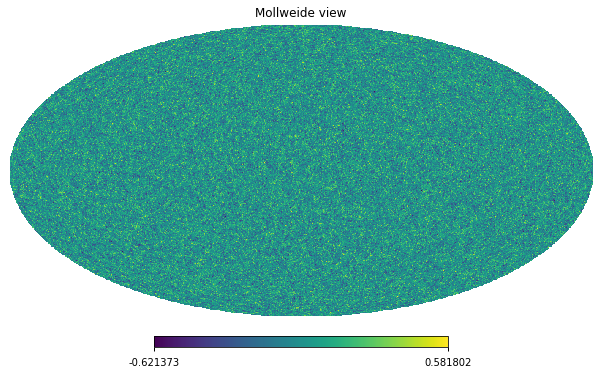

In [37]:
hp.mollview(m_g)

In [38]:
#Calculate pseudo-Cls
cl_cmb_smoothed = hp.anafast(m_k_smoothed, lmax = lmax-1)
cl_cross_smoothed = hp.anafast(m_g, m_k_smoothed, lmax = lmax-1)

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


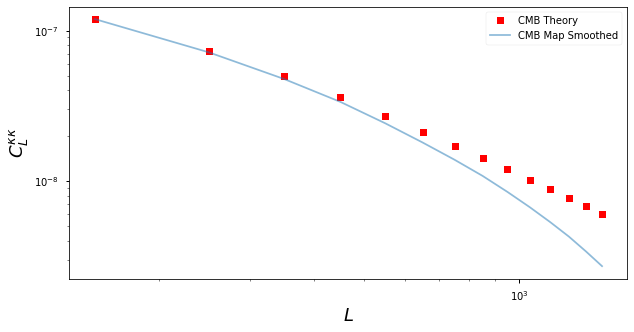

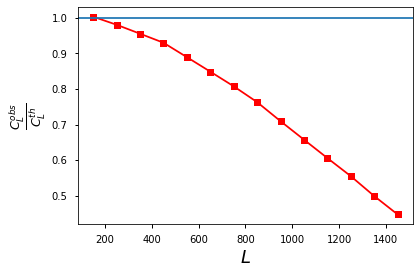

In [39]:
#auto
plt.figure(figsize=(10,5))
plot_powerspectra(cl_cmb_smoothed, 'kk', label = "CMB Map Smoothed")

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


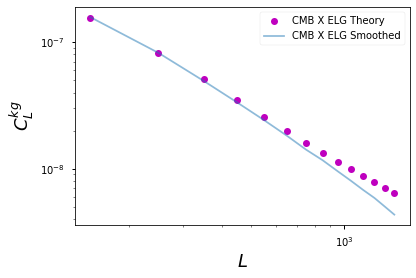

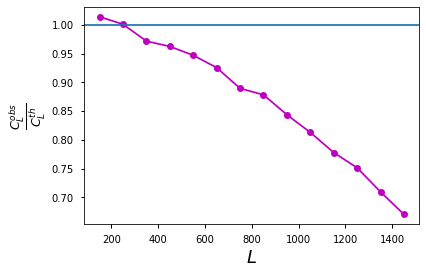

In [40]:
#cross
plot_powerspectra(cl_cross_smoothed, 'kg', label = "CMB X ELG Smoothed")

We notice that beyond $l$ of few hundreds, the observed $C_l$ diverges from theory. We plot the ratio of the smoothed $C_l$ with the theory $C_l$s.

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


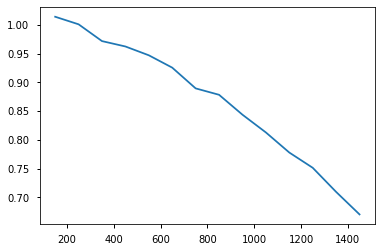

In [44]:
_, cL_cross_smoothed = bin_mat(ell, cl_cross_smoothed, bins)

plt.plot(ELL[ELL > lmin], (cL_cross_smoothed/cLs_cross_th)[ELL > lmin])

We calculate the beam function using Healpy to verify whether this divergence is due to the finite size of the beam.

Text(0, 0.5, '$\\frac{C_{L}^{smooth}}{C_{L}^{th}}$')

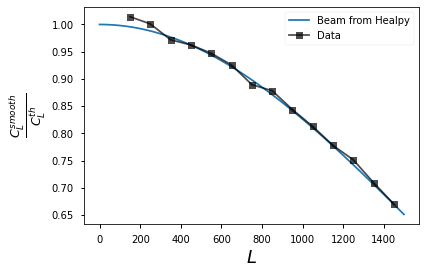

In [49]:
beam = hp.gauss_beam(fwhm=np.deg2rad(FWHM), lmax = lmax - 1)

plt.plot(ell, beam, label = 'Beam from Healpy')
plt.plot(ELL[ELL>lmin], (cL_cross_smoothed/cLs_cross_th)[ELL>lmin], 'ks',
         ls = '-', label = "Data", alpha = 0.7)
plt.legend(loc = 'best')
plt.xlabel(r"$L$", fontsize = fs)
plt.ylabel(r"$\frac{C_{L}^{smooth}}{C_{L}^{th}}$", fontsize = fs)

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Text(0, 0.5, '$C_L$ to healpy beam ratio')

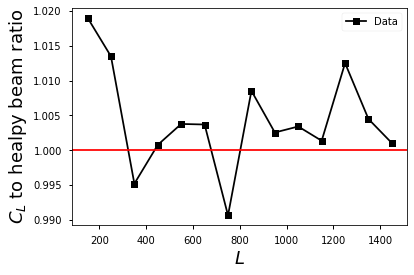

In [52]:
_, beamL = bin_mat(ell, beam, bins)

plt.plot(ELL[ELL>lmin], ((cL_cross_smoothed/cLs_cross_th)/beamL)[ELL>lmin],
         'ks', ls = '-', label = "Data")
plt.axhline(1, c = 'r')
plt.legend(loc = 'best')
plt.xlabel(r"$L$", fontsize = fs)
plt.ylabel(r"$C_L$ to healpy beam ratio", fontsize = fs)

***Conclusion 4: After correcting for the beam function, we recover the $C_l$ value exactly. Therefore, we can account for smoothing in our pipeline.
Note: To correct for CMB Lensing, use beam^2, for Lensing X ELG, use beam.
NtFO: Why?***

#### Test 4: Check the effect of noise on power spectrum recovery

In [53]:
nlkk = np.genfromtxt("data/MV/nlkk.dat")
ell_planck = nlkk[:,0]
N_l = nlkk[:,1]
C_lplusN_l = nlkk[:,2]

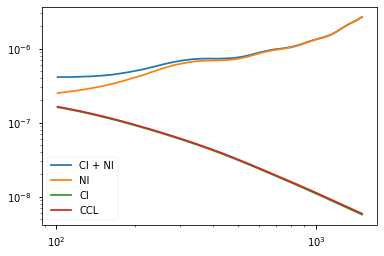

In [45]:
plt.loglog(ell[ell > lmin], (C_lplusN_l[(ell_planck < lmax)])[ell > lmin], label = "Cl + Nl")
plt.loglog(ell[ell > lmin], (N_l[(ell_planck < lmax)])[ell > lmin], label = "Nl")
plt.loglog(ell[ell > lmin], ((C_lplusN_l - N_l)[(ell_planck < lmax)])[ell > lmin], label = "Cl")
plt.loglog(ell[ell > lmin], cls_cmb_th[ell > lmin], label = 'CCL')
plt.legend(loc = 'best')

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Text(0.5, 0, '$l$')

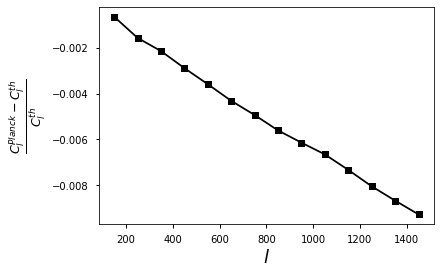

In [63]:
ELL_planck, CL_planck = bin_mat(ell_planck, C_lplusN_l - N_l, np.arange(0, 4096, 100))

plt.plot(ELL[ELL > lmin], (CL_planck[ELL_planck < lmax]/cLs_cmb_th - 1)[ELL > lmin],
         'ks', ls = '-', )
plt.ylabel(r"$\frac{C^{Planck}_{l} - C^{th}_{l}}{C^{th}_{l}}$",fontsize = fs)
plt.xlabel(r'$l$', fontsize = fs)

We notice that there is a clear trend as a function of $l$. The denoised $C_l$ from Planck has a systematic offset from CCL theory by $2\%$. Note that CCL used the same fiducial cosmology as the Planck 2018 Lensing paper. 

#### Metric 1: RCC

\begin{equation}
RCC_{l} = \frac{C^{\kappa g}_{l}}{\sqrt{C^{\kappa \kappa}_{l} C^{gg}_{l}}}
\end{equation}

If $\kappa$ is replaced by $m$, then $RCC = 1$ for systematic-free measurement as it is linear bias independent. Any noticeable deviation from $RCC = 1$ indicates systematics. Here, we calculate what $RCC_{l}$ should be from theory so we can compare observed $RCC$ against this. 

Text(0, 0.5, 'RCC')

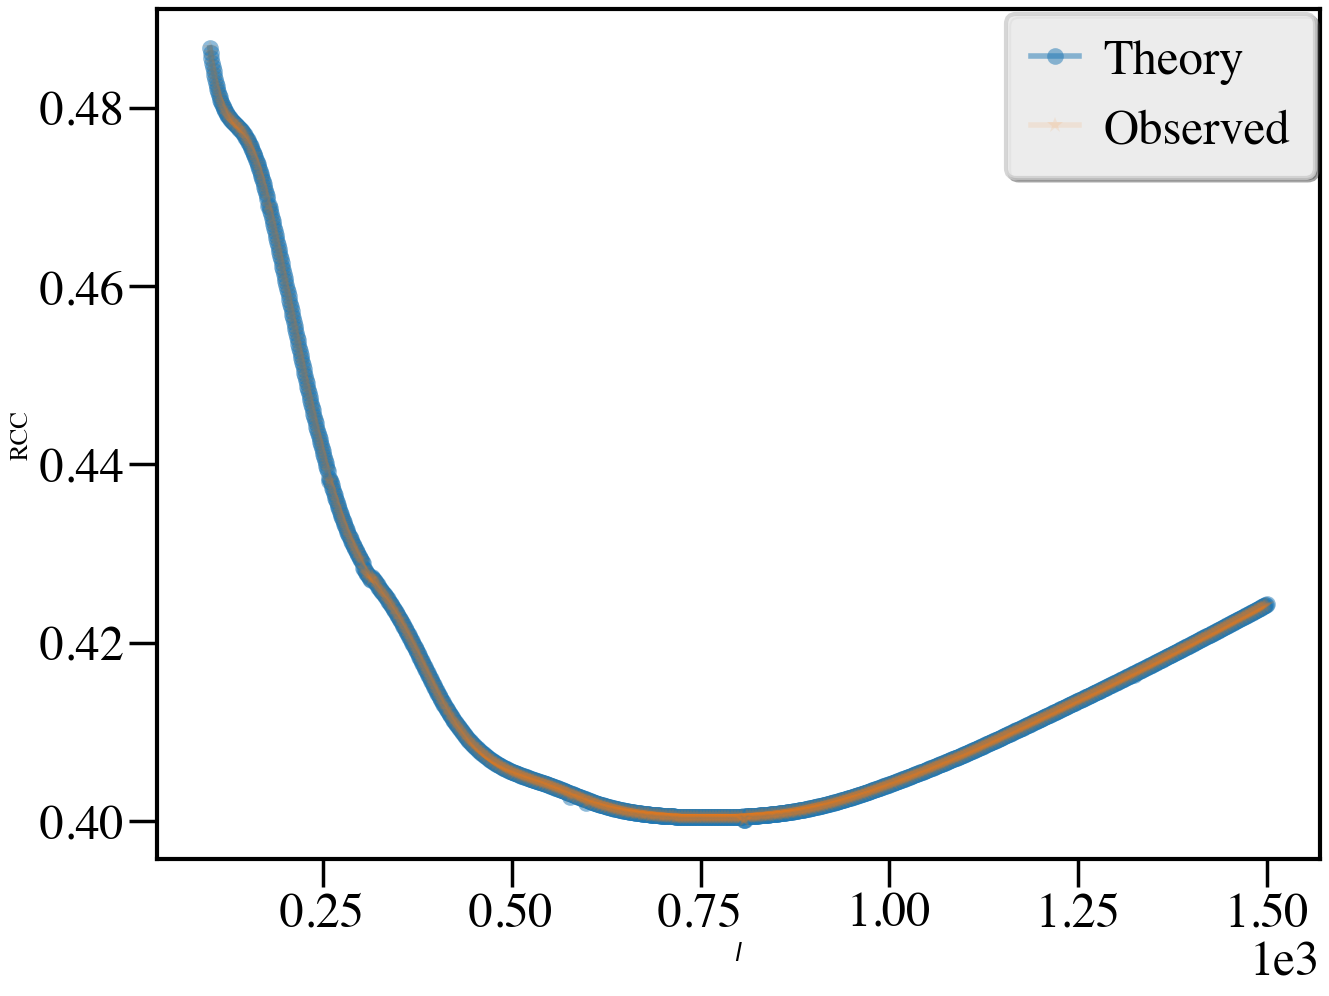

In [44]:
RCC_th = cls_cross_th/np.sqrt(cls_cmb_th * cls_elg_th)
RCC_obs = (cl_cross_masked/fsky_cross)/np.sqrt((cl_cmb_masked/fsky_lensing) * (cl_elg_masked/fsky_elg))
plt.plot(ell[ell > lmin], RCC_th[ell > lmin], label = "Theory", alpha = alpha, marker = "o")
plt.plot(ell[ell > lmin], RCC_th[ell > lmin], label = "Observed", alpha = .1, marker = "*")
plt.legend(loc = 'best')
plt.xlabel(r"$l$", fontsize = fs)
plt.ylabel("RCC", fontsize = fs)

***Observation 1: RCC metric is highly non-linear and not a constant of $1$ as a function of $l$.***

***Conclusion 4: RCC can be recovered almost exactly after correcting for $f_{sky}$.***

## Section 2: Running MCMC Inference 

In this section, we construct an analytic covariance matrix and a script to do cosmological inferences. 

#### Analytic Covariance Matrix

First we bin the data in bins of $100 l$:

In [110]:
#binned Cls by L = 100l
ELL = np.arange(0, lmax+1, 100)
%time ELL_centre, cl_cross_obs_binned = bin_mat(ell, cl_CROSS, ELL)
%time ELL_centre, cl_cross_th_binned = bin_mat(ell, cls_cross_th, ELL)

CPU times: user 12.5 ms, sys: 18 µs, total: 12.5 ms
Wall time: 8.82 ms
CPU times: user 5.58 ms, sys: 50 µs, total: 5.63 ms
Wall time: 5.61 ms


/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


We will use analytic formulation of the covariance matrix for full-sky coverage assuming no noise:

\begin{equation}
\sigma^{2}_{C^{\kappa g}_{l}} = \frac{1}{\left( 2l + 1 \right) f_{sky}} \left[ \left( C^{\kappa g}_{l} \right)^2  + C^{\kappa \kappa}_{l} C^{gg}_{l} \right]
\end{equation}

In [111]:
covCls = 1/fsky_cross * np.diag(1/(2 * ell + 1) * ((cls_cross_th)**2 + cls_cmb_th * cls_elg_th))
covCls_binned = bin_mat(ell, covCls, ELL)[1]
error = np.sqrt(np.diag(covCls_binned))
ivarCls = np.linalg.inv(covCls)
ivarCls_binned = np.linalg.inv(covCls_binned) 

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


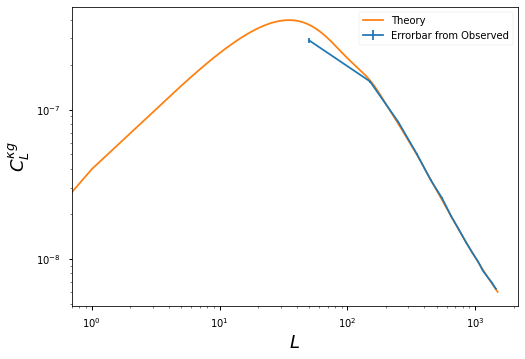

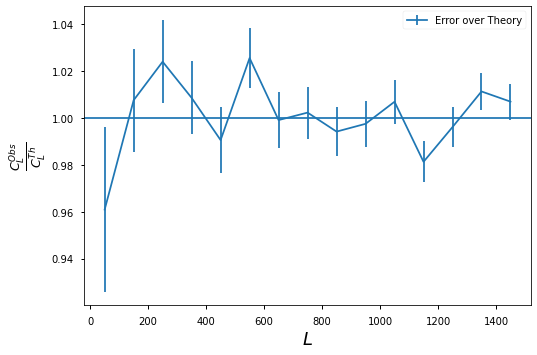

In [113]:
plt.errorbar(ELL_centre, cl_cross_obs_binned, error, label = "Errorbar from Observed")
plt.loglog(ell, cls_cross_th, label = "Theory")
plt.ylabel(r"$C^{\kappa g}_{L}$", fontsize = fs)
plt.xlabel(r"$L$", fontsize = fs)
plt.legend(loc = 'best')
plt.show()
plt.errorbar(ELL_centre, cl_cross_obs_binned/cl_cross_th_binned, error/cl_cross_th_binned,
            label = "Error over Theory")
plt.xlabel(r"$L$", fontsize = fs)
plt.ylabel(r"$\frac{C^{Obs}_{L}}{C^{Th}_{L}}$", fontsize = fs)
plt.axhline(1)
plt.legend(loc = 'best')

We will do inference on two parameters, $\theta$ = [$\Omega_c, \sigma_8$].

In [114]:
import emcee
import corner

In [115]:
#define loglikelihood
#def loglike(theta, data = cl_cross_obs, ivar = ivarCls):
def loglike(theta):
    cosmo = ccl.Cosmology(Omega_c = theta[0], Omega_b = 0.049,
         h = 0.67, n_s = 0.964, sigma8 = theta[1], Omega_k=0,
        transfer_function='bbks')
        
    cmbl = ccl.CMBLensingTracer(cosmo, z_source=1090.)
    elgl = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,dNdz), bias=(z,b))
    model = ccl.angular_cl(cosmo, cmbl, elgl, ell)
    
    _, model_binned = bin_mat(ell, model, ELL)
#     diff = cl_cross_obs - model
    diff = cl_cross_obs_binned - model_binned
    
    return -0.5 * (diff).T @ ivarCls_binned @ diff

In [116]:
#utils functions 
def mcmc(loglikelihood, init_pos, nsamples, thread):
    """Returns emcee sampler based on log likelihood,
    initial position and number of walkers."""
    
    nwalkers = init_pos.shape[0]
    ndim = init_pos.shape[1]
    #initiate sampler and run
    sampler = emcee.EnsembleSampler(nwalkers, ndim, loglikelihood, threads=thread)
    sampler.run_mcmc(p0, nsamples, progress=True);
    
    return sampler

def trace_autocorr(sampler, labels):
    """Returns traceplots and autocorrelation time
    of parameters based on emcee chain output.
    
    Parameters
    ----------
    samples : sampler.get_chain() output from emcee
    labels : names of parameters 
    """
    
    samples = sampler.get_chain()
    ndim = samples.shape[2]
    fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
    
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i], fontsize = 15)
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number");
    
    #check auto-correlation time
    tau = sampler.get_autocorr_time()
    print(tau)
    
def burn_thin(sampler,  burn_in, thinning):
    """Returns flattened chains after burn-in and thinning."""
    
    flat_samples = sampler.get_chain(discard=burn_in, thin=thinning,
                    flat=True)
    return flat_samples

def cornerplot(flat_samples, **kwargs):
    figure = corner.corner(flat_samples, **kwargs)

In [117]:
#setup walkers
nwalkers = 10; ndim = 2
np.random.seed(24)
p0 = np.random.multivariate_normal(mean = np.array([0.268, 0.812]), 
                                cov = np.array([[0.00001, 0], [0, 0.00001]]), 
                              size = nwalkers)

In [118]:
def mcmc_parallel(loglikelihood, init_pos, nsamples):

    nwalkers = init_pos.shape[0]
    ndim = init_pos.shape[1]
    
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(
            nwalkers, ndim, loglikelihood, pool=pool)
        #start = time.time()
        sampler.run_mcmc(p0, nsamples, progress=True);
        #end = time.time()
        #multi_data_time = end - start
        print("Multiprocessing took {0:.1f} seconds".format(multi_data_time))
        #print(
        #    "{0:.1f} times faster(?) than serial".format(serial_data_time / multi_data_time)
        #)

In [119]:
%time loglike(p0[0]+.2)

CPU times: user 473 ms, sys: 643 µs, total: 474 ms
Wall time: 207 ms


/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


-135858.29134465338

In [121]:
#run sampler
%time sampler = mcmc(loglikelihood=loglike, init_pos=p0, nsamples=400, thread = 7)

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
100%|██████████| 400/400 [14:46<00:00,  2.22s/it]

CPU times: user 37min 32s, sys: 1.16 s, total: 37min 33s
Wall time: 14min 48s


AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 8;
tau: [25.43165165 24.34908891]

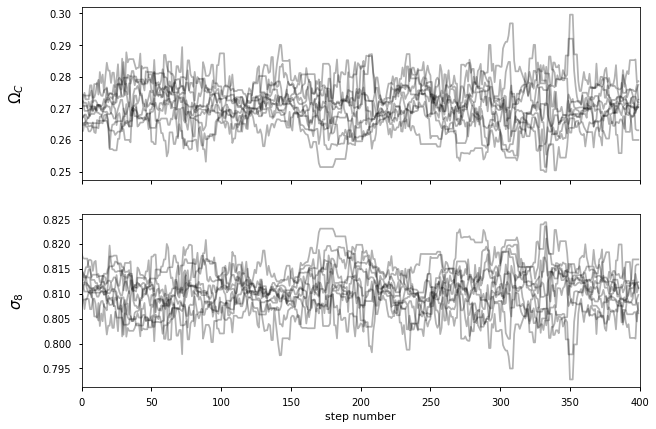

In [122]:
trace_autocorr(sampler, [r"$\Omega_C$", "$\sigma_8$"])

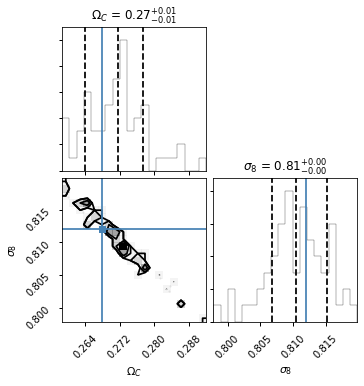

In [123]:
#burn-in and thinning
flat_samples = burn_thin(sampler, 100, 50)

#cornerplot
cornerplot(flat_samples, labels = [r"$\Omega_C$", "$\sigma_8$"],
        quantiles=np.array([.16, .5, .84]), truths=np.array([0.268, 0.812]),
        show_titles=True, title_kwargs={"fontsize": 12})

Observations:
- The sampler takes an unusually long amount of time to run. Each iteration takes roughly $7.5$ seconds to compute which makes this procedure very expensive, even for two parameters. 
- The autocorrelation time diagnostic suggests that 1000 points are not enough and we need to run the chain longer. However, with each iteration taking $7.5$ seconds, this becomes a very expensive procedure. 
- The final result is nowhere near the truth. Even with $0$ noise and full-sky signal, the inferred $\Omega_{C}$ is really off, and the $\sigma_{8}$ measurement is somewhat off. 

In [ ]:
from multiprocessing import Pool

#run sampler
sampler = mcmc_parallel(loglikelihood=loglike, init_pos=p0, nsamples=5)